## Helper function to load and save images in the appropriate format

In [9]:
import numpy as np
from PIL import Image
def loadImgToArray(url,info=False):
    """
    take the url and return the image (PIL format) as a numpy Array
    """
    image = Image.open(url)
    imgArray = np.asarray(image)
    if info:
        print(f'From: {type(image)}, Size: {image.size}, Mode: {image.mode}\nTo: {type(imgArray)}, shape: {imgArray.shape}')
    
    return imgArray

In [10]:
def saveArrayToImg(url,npArray,info=False):
    """
    Takes a numpy array and converts it 
    """
    image = Image.fromarray(npArray)
    if info:
        print(f'From: {type(npArray)}, shape: {npArray.shape}\nTo: {type(image)}, Size: {image.size}, Mode: {image.mode}')
    image.save(url)

In [165]:
# test
mainUrl = '/home/henri/Desktop/roboflow/quickTest/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

imgArray = loadImgToArray(mainUrl+'2.jpg', info=True)
saveArrayToImg(testUrl+'.jpg', npArray,info=True)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1000, 1627), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)
From: <class 'numpy.ndarray'>, shape: (2571, 1987, 3)
To: <class 'PIL.Image.Image'>, Size: (1987, 2571), Mode: RGB


## Helper functions

In [92]:
from io import StringIO 
def loadingBBox(fileurl,imageArray,info=True):
    """
    Assuming the data is in this format (yolo)
    <object-class> <x> <y> <width> <height> 
    [1.      , 0.250126, 0.29366 , 0.471062, 0.410735]
    the fucntion will return the following format
    <object-class> <x1> <y1> <x2> <y2>

    The following code allowed to push through
    https://github.com/dnissimi/imgaug-yolov3/blob/master/imgaug-yolov3.py

    *rant warning*
    legit the reason why it is so complex is that the yolo format values are kept between 0-1 and that they are multiplied by the file's shape
    so they have to be 'hydrated' by multiplying each values by their corresponding image height or width.
    i.e. if a box width and height are both .5 that mean the box essentially takes half of the screen area.
    The only thing I don't quite understand in the calculations is why Wbox/hbox have to be divided by 2. Clue yolo x,y indicates the center of the box so you have to push the coordinate to the left by half (since the value is in the center)

    """
    # width/height of the orginal image
    width = imageArray.shape[1] #width or x axis
    height = imageArray.shape[0] #height of y axis
    boxData = np.loadtxt(fileurl)
    
    x1 = boxData[:,1:2:] * width - (boxData[:,3:4:] * width / 2)
    y1 = boxData[:,2:3:] * height - (boxData[:,4:5:] * height / 2)
    x2 = boxData[:,3:4:] * width + x1
    y2 = boxData[:,4:5:] * height + y1
    scaledtransformed = np.column_stack([boxData[:,0:1:],x1,y1,x2,y2])
    if info:
        print(f'\nimage width: {width} and height {height}')
        print(f'before transform <object-class> <x> <y> <width> <height>:\n{boxData}\n after transform <object-class> <x1> <y1> <x2> <y2>:\n{scaledtransformed}')

    return scaledtransformed

In [107]:
# test (loading boxes)
mainUrl = '/home/henri/Desktop/roboflow/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'
npArray = loadImgToArray(testUrl+'60.jpg', info=True)
boxData = loadingBBox(testUrl+'60.txt', imgArray, info=True)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1987, 2571), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (2571, 1987, 3)

image width: 1000 and height 1627
before transform <object-class> <x> <y> <width> <height>:
[[1.       0.59235  0.332555 0.116759 0.318942]
 [1.       0.733266 0.309218 0.116759 0.318942]
 [1.       0.892803 0.315247 0.157021 0.321665]
 [1.       0.250126 0.29366  0.471062 0.410735]
 [1.       0.129592 0.801828 0.258178 0.373785]
 [1.       0.383996 0.809996 0.258681 0.373785]
 [1.       0.745848 0.696811 0.45697  0.232205]
 [1.       0.748364 0.909374 0.445898 0.181252]
 [0.       0.417715 0.449825 0.154001 0.085959]
 [0.       0.192753 0.93485  0.154001 0.085959]
 [0.       0.43533  0.93485  0.154001 0.085959]
 [0.       0.646704 0.777713 0.154001 0.085959]
 [0.       0.902869 0.941462 0.154001 0.085959]
 [0.       0.901862 0.445935 0.154001 0.085959]
 [0.       0.736789 0.4648   0.082536 0.035784]
 [0.       0.616507 0.463633 0.082536 0.035784]]
 afte

In [109]:
def saveBBox(fileurl,boxData,imageArray,info=True):
    """
    Assuming the data is in this format (yolo)
    <object-class> <x1> <y1> <x2> <y2> 
    the fucntion will return the following format
    <object-class> <x> <y> <width> <height>

    Doesn't take into account boxes that fell outside the image size post transformation
    """
    # width/height of the transfomer image
    width = imageArray.shape[1] #width or x axis
    height = imageArray.shape[0] #height of y axis

    x_pos = boxData[:,1:2:] / width - (( boxData[:,1:2:] - boxData[:,3:4:]) / width / 2)
    y_pos = boxData[:,2:3:] / height - ((boxData[:,2:3:] - boxData[:,4:5:]) / height /2)
    # the original repo had an error there
    x_size = (boxData[:,3:4:] - boxData[:,1:2:]) / width 
    y_size = (boxData[:,4:5:] - boxData[:,2:3:]) / height
    scaledtransformed  = np.column_stack([boxData[:,0:1:],x_pos,y_pos,x_size,y_size])

    # normally we 
    if info:
        print(f'\nimage width: {width} and height {height}')
        print(f'before transform\n<object-class> <x1> <y1> <x2> <y2>:\n{boxData} after transform <object-class> <x> <y> <width> <height>:\n{scaledtransformed}')
    
    np.savetxt(fileurl, scaledtransformed,fmt='%f', delimiter=' ')

In [ ]:
def showImg(imgArray):
    """
    takes a numpy array and display as a picture
    """  
    imgplot = plt.imshow(imgArray)
    plt.show()

In [110]:
saveBBox(testUrl+'136.txt', boxData, imgArray, info=True)


image width: 1000 and height 1627
before transform
<object-class> <x1> <y1> <x2> <y2>:
[[1.00000000e+00 5.33970500e+02 2.81607668e+02 6.50729500e+02
  8.00526302e+02]
 [1.00000000e+00 6.74886500e+02 2.43638369e+02 7.91645500e+02
  7.62557003e+02]
 [1.00000000e+00 8.14292500e+02 2.51232392e+02 9.71313500e+02
  7.74581346e+02]
 [1.00000000e+00 1.45950000e+01 1.43651897e+02 4.85657000e+02
  8.11917743e+02]
 [1.00000000e+00 5.03000000e-01 1.00050006e+03 2.58681000e+02
  1.60864825e+03]
 [1.00000000e+00 2.54655500e+02 1.01378939e+03 5.13336500e+02
  1.62193759e+03]
 [1.00000000e+00 5.17363000e+02 9.44812730e+02 9.74333000e+02
  1.32261026e+03]
 [1.00000000e+00 5.25415000e+02 1.33210300e+03 9.71313000e+02
  1.62700000e+03]
 [0.00000000e+00 3.40714500e+02 6.61937628e+02 4.94715500e+02
  8.01792921e+02]
 [0.00000000e+00 1.15752500e+02 1.45107330e+03 2.69753500e+02
  1.59092860e+03]
 [0.00000000e+00 3.58329500e+02 1.45107330e+03 5.12330500e+02
  1.59092860e+03]
 [0.00000000e+00 5.69703500e+02 

In [113]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

imageArray = loadImgToArray(mainUrl+'2.jpg', info=True)
Bdata = loadingBBox(mainUrl+'2.txt',imageArray,info=True)

bbs = list()
for box in Bdata:
    Bclass,x1,y1,x2,y2 = box
    bbs.append(BoundingBox(label=Bclass,x1=x1, y1=y1, x2=x2, y2=y2))
bbs = BoundingBoxesOnImage(bbs,shape=imageArray.shape)

From: <class 'PIL.JpegImagePlugin.JpegImageFile'>, Size: (1000, 1627), Mode: RGB
To: <class 'numpy.ndarray'>, shape: (1627, 1000, 3)

image width: 1000 and height 1627
before transform <object-class> <x> <y> <width> <height>:
[[0.       0.135    0.181623 0.12     0.081746]
 [0.       0.8425   0.077136 0.121    0.081746]
 [0.       0.549    0.401967 0.12     0.08236 ]
 [0.       0.12     0.434235 0.12     0.081746]
 [0.       0.7055   0.572219 0.121    0.08236 ]
 [0.       0.397    0.584819 0.12     0.081746]
 [0.       0.115    0.603258 0.12     0.081746]
 [0.       0.1105   0.792256 0.119    0.08236 ]
 [0.       0.432    0.786417 0.12     0.081746]
 [0.       0.7155   0.7941   0.121    0.08236 ]
 [1.       0.2455   0.246159 0.391    0.247695]
 [1.       0.52     0.854026 0.296    0.202213]
 [1.       0.245    0.474186 0.36     0.183774]
 [1.       0.7105   0.425323 0.531    0.2311  ]
 [1.       0.7155   0.205286 0.481    0.26429 ]
 [1.       0.8025   0.846036 0.297    0.202213]
 [1.  

In [120]:
%pylab inline
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [123]:
#setting the pipeline
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

In [124]:
# Augment BBs and images.
image_aug, bbs_aug = seq(image=imageArray, bounding_boxes=bbs)

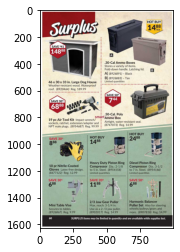

In [167]:
# before picture 
showImg(imageArray)

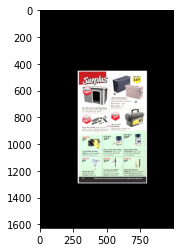

In [125]:
# after picture
showImg(image_aug)

In [159]:
def bboxNPPacker(bbox):
    packer = np.empty([len(bbox.bounding_boxes), 5])
    for idx in range(len(bbox.bounding_boxes)):
        bboxIdx = bbox.bounding_boxes[idx]
        packer[idx] = [bboxIdx.label,bboxIdx.x1,bboxIdx.y1,bboxIdx.x2,bboxIdx.y2]
    return packer

In [162]:
testUrl = '/home/henri/Desktop/roboflow/quickTest/'
saveArrayToImg(testUrl+'2.jpg', image_aug,info=False)
saveBBox(testUrl+'2.txt', bboxNPPacker(bbs_aug), image_aug, info=False)

## End of test

In [ ]:
mainUrl = '/home/henri/Desktop/roboflow/'
testUrl = '/home/henri/Desktop/roboflow/quickTest/'

In [222]:
#setting the pipeline
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([

# the most important part of the image transformation

    sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.2),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),

# everything bellow is nice but not required 


        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True)
])

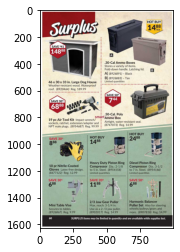

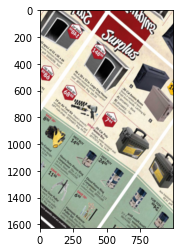

BoundingBoxesOnImage([BoundingBox(x1=365.5051, y1=229.0949, x2=515.0433, y2=397.5126, label=0.0), BoundingBox(x1=923.6445, y1=500.1503, x2=1073.8457, y2=669.1332, label=0.0), BoundingBox(x1=451.0373, y1=733.8612, x2=601.1012, y2=903.0344, label=0.0), BoundingBox(x1=139.2827, y1=531.4555, x2=288.8209, y2=699.8732, label=0.0), BoundingBox(x1=408.6874, y1=1031.5343, x2=559.4143, y2=1201.2727, label=0.0), BoundingBox(x1=193.9848, y1=873.3215, x2=343.5229, y2=1041.7391, label=0.0), BoundingBox(x1=-8.7442, y1=736.6122, x2=140.7940, y2=905.0299, label=0.0), BoundingBox(x1=-173.4730, y1=966.5356, x2=-24.0720, y2=1135.1437, label=0.0), BoundingBox(x1=44.5847, y1=1141.1715, x2=194.1229, y2=1309.5892, label=0.0), BoundingBox(x1=225.3488, y1=1310.2115, x2=376.0757, y2=1479.9500, label=0.0), BoundingBox(x1=222.6383, y1=192.2752, x2=693.9069, y2=718.0741, label=1.0), BoundingBox(x1=-64.8701, y1=1150.2471, x2=304.4813, y2=1566.3823, label=1.0), BoundingBox(x1=64.7158, y1=520.6687, x2=460.7069, y2=950

In [223]:
image_aug, bbs_aug = seq(image=imageArray, bounding_boxes=bbs)
showImg(imageArray)
showImg(image_aug)
bbs_aug

In [188]:
saveArrayToImg(testUrl+'2.jpg', image_aug,info=False)
saveBBox(testUrl+'2.txt', bboxNPPacker(bbs_aug), image_aug, info=False)

In [214]:
def augmentedCopiesSingleImage(imgArray,bbox,amount,info=False):
    results = dict()
    for i in range(0,amount):
        results[i] = seq(image=imgArray, bounding_boxes=bbox)
    return results

In [215]:
#easier to load files into dict dict(idx) = [img,box]


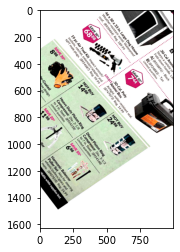

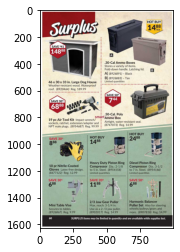

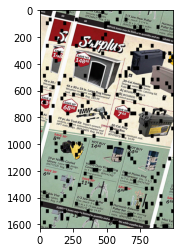

In [224]:
test = augmentedCopiesSingleImage(imageArray,bbs,3)
for i in range(len(test)):
    showImg(test[i][0])